In [42]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing:

In [43]:
# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over all files matching the pattern
for file in glob.glob("../subject-*.csv"):
    if "recall" in file or "Recall" in file:
        continue
    # Read the CSV file into a DataFrame
    temp_df = pd.read_csv(file)
    
    # Extract the subject number from the filename
    subject_number = os.path.basename(file).split('-')[1].split('.')[0]
    
    # Add a new column for the subject number
    temp_df['subject_number'] = subject_number
    
    # Append the DataFrame to the list
    dataframes.append(temp_df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(dataframes, ignore_index=True)

# Display the resulting DataFrame
# print(all_data)

In [44]:
# Remove rows where 'trial' is not numeric
all_data = all_data[pd.to_numeric(all_data['trial'], errors='coerce').notnull()]

# Remove rows where 'rt' is 'inf'
all_data = all_data[all_data['rt'] != 'inf']

# Convert 'rt', 'start_time', 'time_bar', 'expected_rt', and 'alpha' to numeric, coercing errors to NaN
all_data['rt'] = pd.to_numeric(all_data['rt'], errors='coerce')
all_data['start_time'] = pd.to_numeric(all_data['start_time'], errors='coerce')
all_data['time_bar'] = pd.to_numeric(all_data['time_bar'], errors='coerce')
all_data['expected_rt'] = pd.to_numeric(all_data['expected_rt'], errors='coerce')
all_data['alpha'] = pd.to_numeric(all_data['alpha'], errors='coerce')
all_data['subject_number'] = pd.to_numeric(all_data['subject_number'], errors='coerce')
all_data['trial'] = pd.to_numeric(all_data['trial'], errors='coerce')
all_data['fact_id'] = pd.to_numeric(all_data['fact_id'], errors='coerce')

# Convert columns with 'True' and 'False' strings to boolean values
bool_columns = ['new', 'on_time', 'time_bar_visible', 'correct']
for col in bool_columns:
    all_data[col] = all_data[col].map({'True': True, 'False': False})

# Apply log transformation to 'rt' 
all_data['log_rt'] = np.log(all_data['rt'])

# Filter the DataFrame to include only rows where 'new' is False
filtered_data = all_data[all_data['new'] == False]

In [63]:
# Group by 'subject_number' and extract 'question', 'answer', and 'time_bar_visible'
subject_words = all_data.groupby('subject_number')[['question', 'answer', 'time_bar_visible']].apply(lambda x: x.reset_index(drop=True))

# Reset the index to include 'subject_number' in the CSV
subject_words = subject_words.reset_index()

# Drop duplicate rows to ensure unique combinations
subject_words = subject_words.drop_duplicates(subset=['question', 'answer', 'time_bar_visible', 'subject_number'])

# Display the resulting DataFrame
# print(subject_words)

subject_words.to_csv('subject_words_timebar.csv', index=False)

# Boxplot of reaction time and log transformed reaction time over all trials:

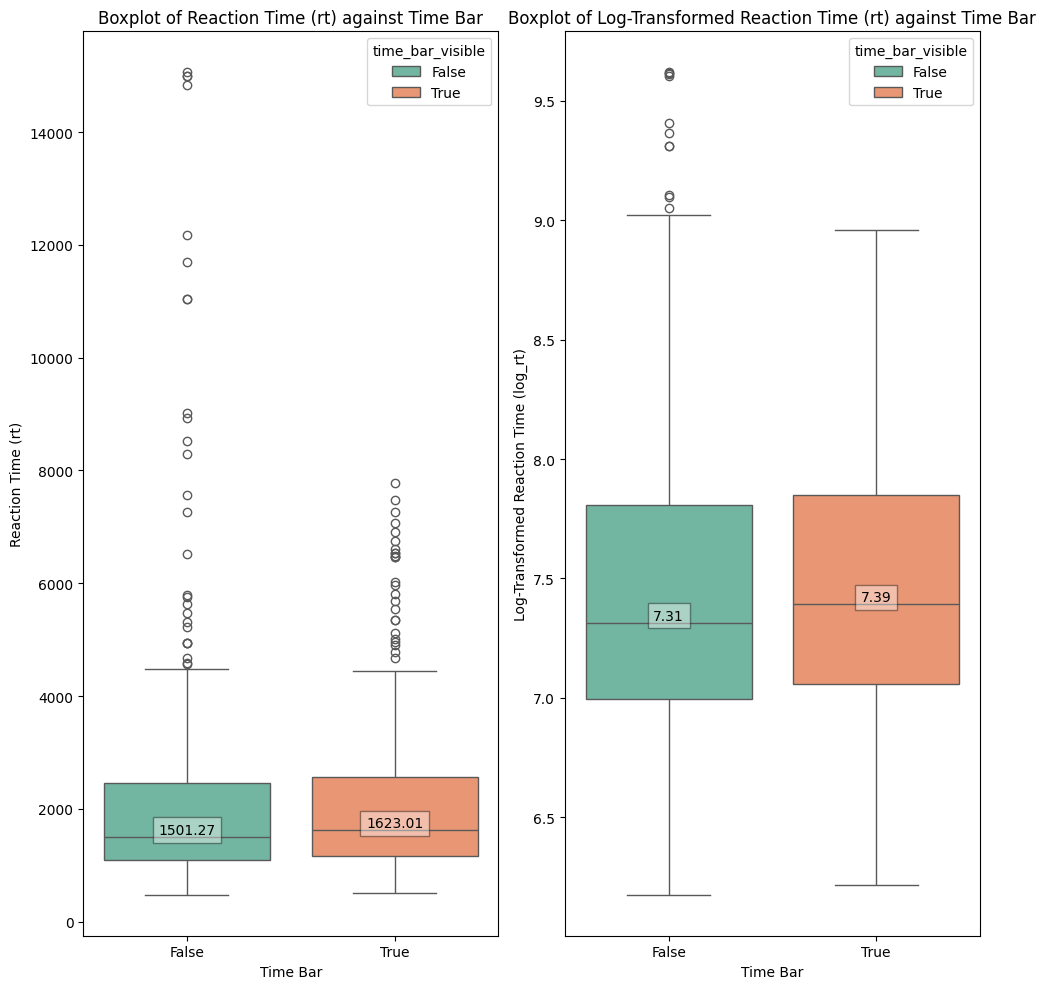

In [129]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Create the first boxplot
sns.boxplot(ax=axes[0], x='time_bar_visible', y='rt', data=filtered_data, palette='Set2', hue='time_bar_visible')
axes[0].set_title('Boxplot of Reaction Time (rt) against Time Bar')
axes[0].set_xlabel('Time Bar')
axes[0].set_ylabel('Reaction Time (rt)')

# Calculate and annotate the medians for 'rt'
medians_rt = filtered_data.groupby('time_bar_visible')['rt'].median()
for i, median in enumerate(medians_rt):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Create the second boxplot with log-transformed 'rt'
sns.boxplot(ax=axes[1], x='time_bar_visible', y='log_rt', data=filtered_data, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Boxplot of Log-Transformed Reaction Time (rt) against Time Bar')
axes[1].set_xlabel('Time Bar')
axes[1].set_ylabel('Log-Transformed Reaction Time (log_rt)')

# Calculate and annotate the medians for 'log_rt'
medians_log_rt = filtered_data.groupby('time_bar_visible')['log_rt'].median()
for i, median in enumerate(medians_log_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# Distributions of reaction times

### not sure if this is needed

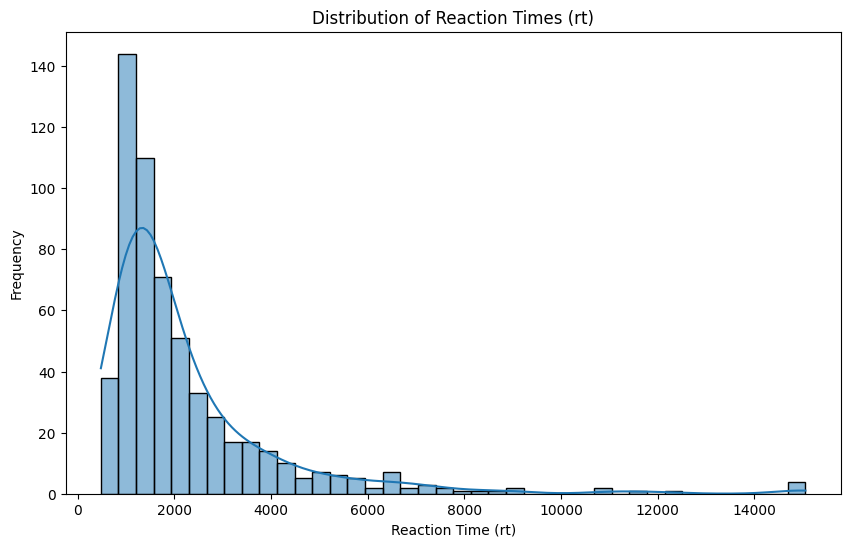

In [98]:
# Create a distribution plot for the reaction times (rt)
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['rt'], bins=40, kde=True)
plt.title('Distribution of Reaction Times (rt)')
plt.xlabel('Reaction Time (rt)')
plt.ylabel('Frequency')
plt.show()

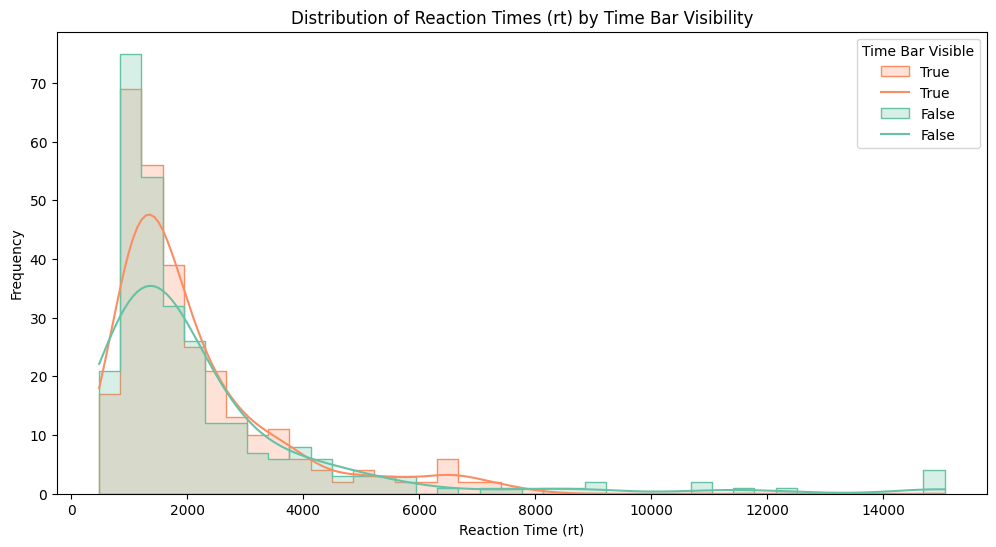

In [123]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=filtered_data, x='rt', hue='time_bar_visible', bins=40, kde=True, element='step', palette='Set2')
plt.title('Distribution of Reaction Times (rt) by Time Bar Visibility')
plt.xlabel('Reaction Time (rt)')
plt.ylabel('Frequency')
ax.legend(title='Time Bar Visible', labels=['True', 'True', 'False', 'False'])
plt.show()

# The following data is first averaged for each subject:

In [52]:
# Group by 'subject_number' and 'time_bar_visible' and calculate additional statistics
evals = filtered_data.groupby(['subject_number', 'time_bar_visible']).agg(
    accuracy=('correct', 'mean'),
    mean_rt=('rt', 'mean'),
    std_rt=('rt', 'std'),
    median_rt=('rt', 'median'),
    mean_expected_rt=('expected_rt', 'mean'),
    percentage_on_time=('on_time', lambda x: (x.sum() / len(x)) * 100),
    unique_fact_id=('fact_id', 'nunique'),
    trial_count=('trial', 'count')
).reset_index()

# Display the eval DataFrame with additional statistics
# print(evals)

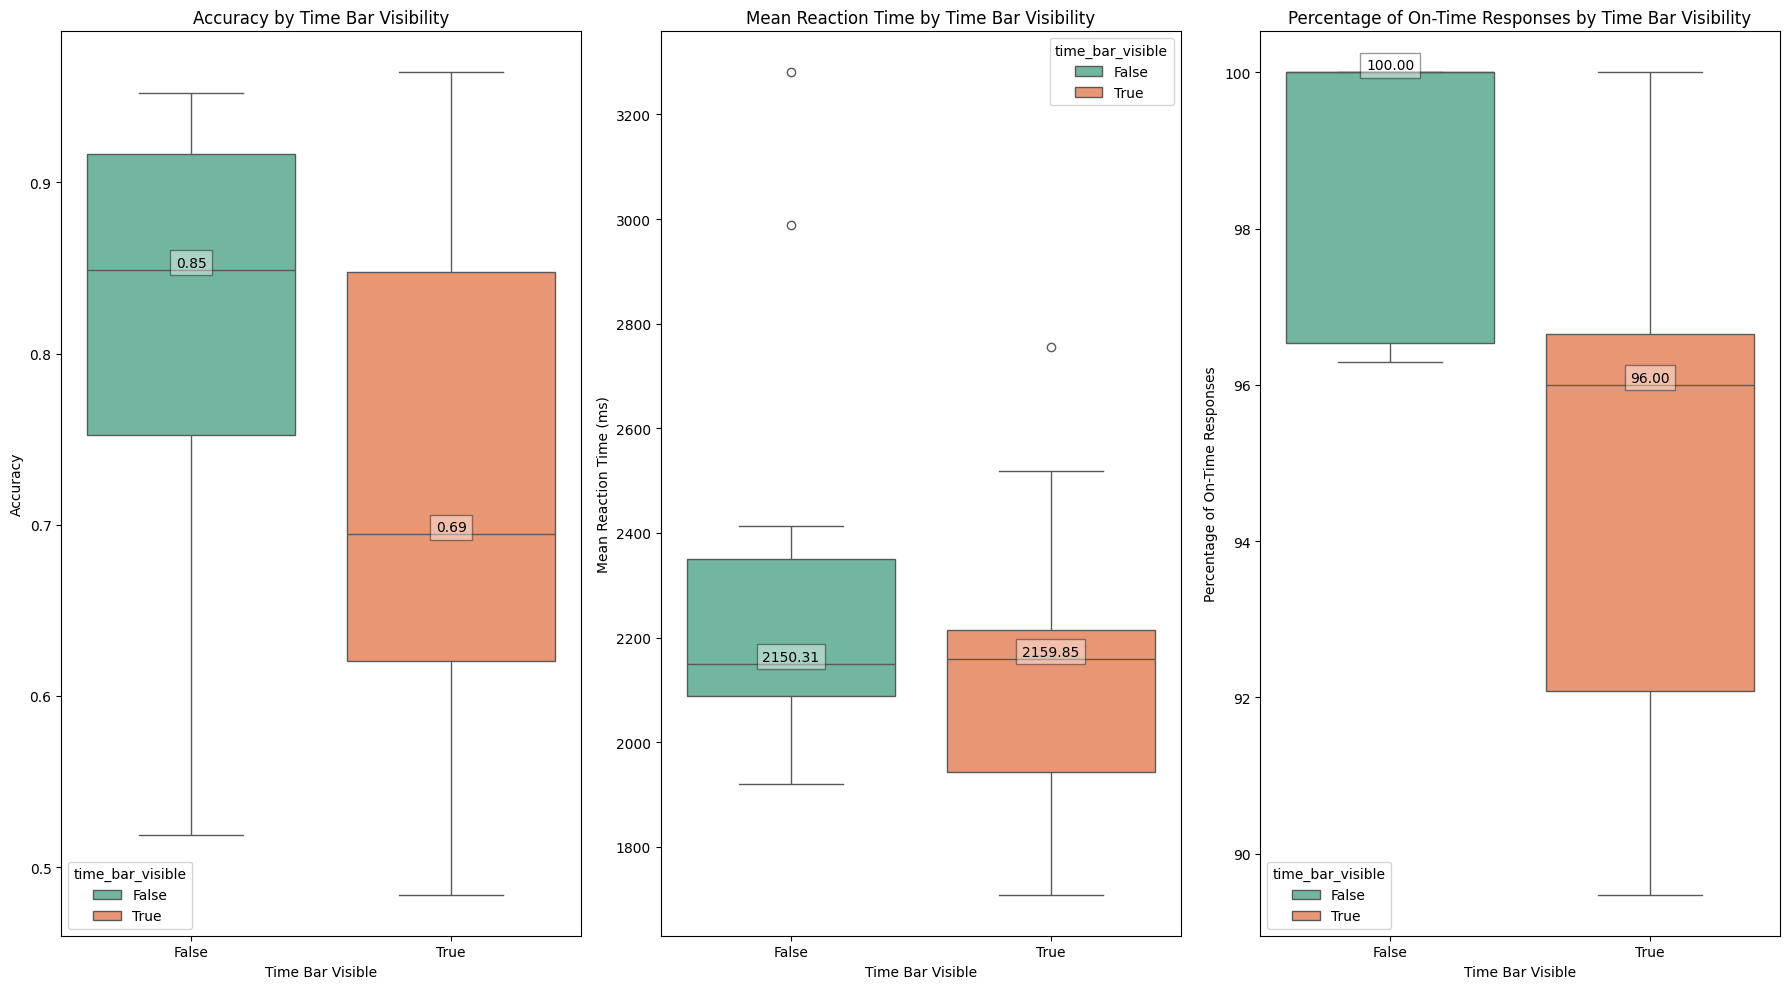

In [143]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Plot accuracy
sns.boxplot(ax=axes[0], x='time_bar_visible', y='accuracy', data=evals, palette='Set2', hue='time_bar_visible')
axes[0].set_title('Accuracy by Time Bar Visibility')
axes[0].set_xlabel('Time Bar Visible')
axes[0].set_ylabel('Accuracy')

# Calculate and annotate the medians for 'accuracy'
medians_accuracy = evals.groupby('time_bar_visible')['accuracy'].median()
for i, median in enumerate(medians_accuracy):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Plot mean reaction time
sns.boxplot(ax=axes[1], x='time_bar_visible', y='mean_rt', data=evals, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Mean Reaction Time by Time Bar Visibility')
axes[1].set_xlabel('Time Bar Visible')
axes[1].set_ylabel('Mean Reaction Time (ms)')

# Calculate and annotate the medians for 'mean_rt'
medians_mean_rt = evals.groupby('time_bar_visible')['mean_rt'].median()
for i, median in enumerate(medians_mean_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Plot percentage of on-time responses
sns.boxplot(ax=axes[2], x='time_bar_visible', y='percentage_on_time', data=evals, palette='Set2', hue='time_bar_visible')
axes[2].set_title('Percentage of On-Time Responses by Time Bar Visibility')
axes[2].set_xlabel('Time Bar Visible')
axes[2].set_ylabel('Percentage of On-Time Responses')

# Calculate and annotate the medians for 'percentage_on_time'
medians_on_time = evals.groupby('time_bar_visible')['percentage_on_time'].median()
for i, median in enumerate(medians_on_time):
    axes[2].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# The following plot simply takes the accuracy and mean reaction time of all trials:

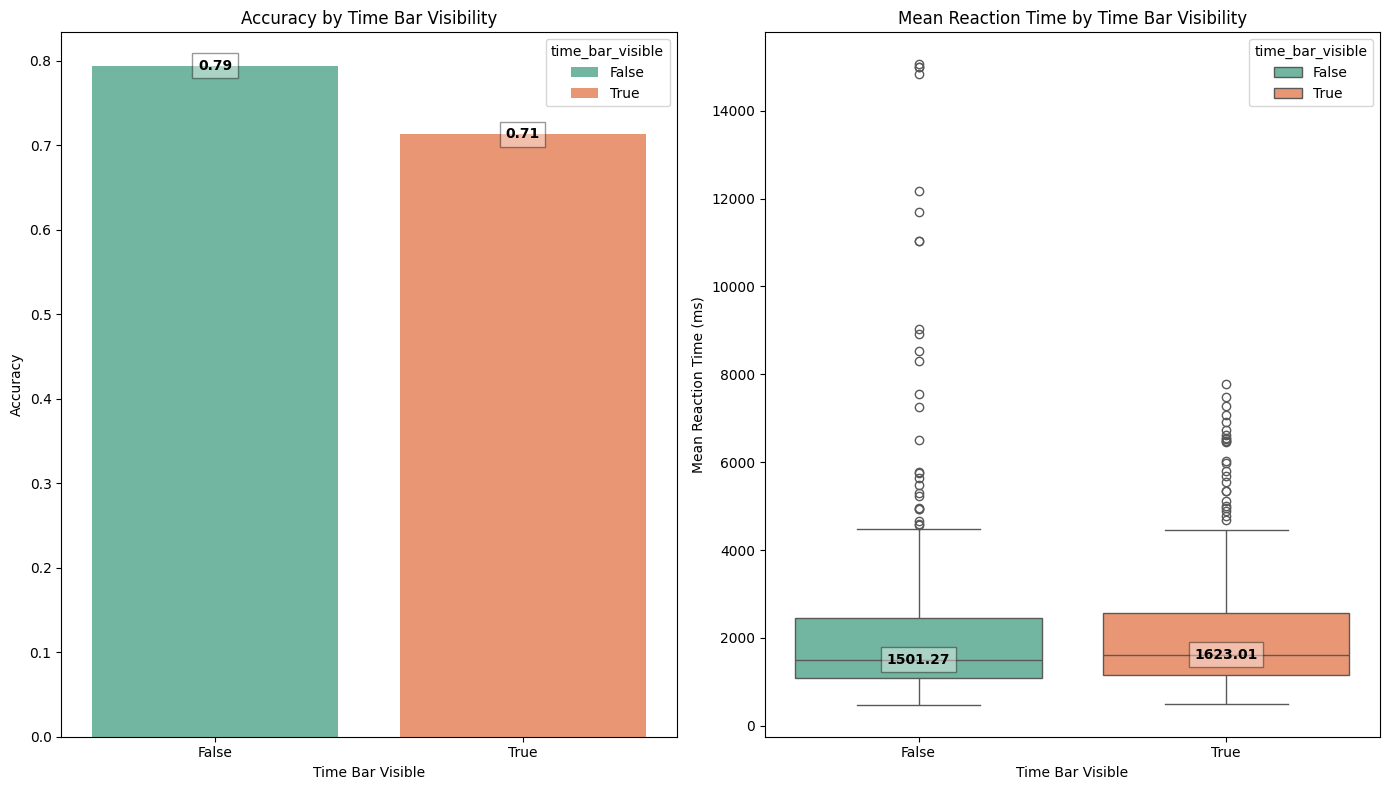

In [140]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot accuracy as a barplot
sns.barplot(ax=axes[0], x='time_bar_visible', y='correct', data=filtered_data, palette='Set2', hue='time_bar_visible', errorbar=None)
axes[0].set_title('Accuracy by Time Bar Visibility')
axes[0].set_xlabel('Time Bar Visible')
axes[0].set_ylabel('Accuracy')

# Calculate and add median values for accuracy
median_accuracy = filtered_data.groupby('time_bar_visible')['correct'].mean()
for i, median in enumerate(median_accuracy):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Plot mean reaction time
sns.boxplot(ax=axes[1], x='time_bar_visible', y='rt', data=filtered_data, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Mean Reaction Time by Time Bar Visibility')
axes[1].set_xlabel('Time Bar Visible')
axes[1].set_ylabel('Mean Reaction Time (ms)')

# Calculate and add median values for mean reaction time
median_rt = filtered_data.groupby('time_bar_visible')['rt'].median()
for i, median in enumerate(median_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# Some T-tests, first, the accuracy, mean, percentage on time is calculated per subject:

In [58]:
from scipy.stats import ttest_ind

# Separate the data based on time_bar_visible condition
accuracy_false = evals[evals['time_bar_visible'] == False]['accuracy']
accuracy_true = evals[evals['time_bar_visible'] == True]['accuracy']

mean_rt_false = evals[evals['time_bar_visible'] == False]['mean_rt']
mean_rt_true = evals[evals['time_bar_visible'] == True]['mean_rt']

on_time_false = evals[evals['time_bar_visible'] == False]['percentage_on_time']
on_time_true = evals[evals['time_bar_visible'] == True]['percentage_on_time']

# Perform t-tests
t_stat_accuracy, p_value_accuracy = ttest_ind(accuracy_false, accuracy_true)
t_stat_mean_rt, p_value_mean_rt = ttest_ind(mean_rt_false, mean_rt_true)
t_stat_on_time, p_value_on_time = ttest_ind(on_time_false, on_time_true)

# Print the results
print(f"Accuracy t-test: t-statistic = {t_stat_accuracy}, p-value = {p_value_accuracy}")
print(f"Mean Reaction Time t-test: t-statistic = {t_stat_mean_rt}, p-value = {p_value_mean_rt}")
print(f"On-Time Percentage t-test: t-statistic = {t_stat_on_time}, p-value = {p_value_on_time}")

Accuracy t-test: t-statistic = 1.1234755221902644, p-value = 0.27599683173109185
Mean Reaction Time t-test: t-statistic = 0.9876662643191563, p-value = 0.3364075373916685
On-Time Percentage t-test: t-statistic = 2.7585874489884, p-value = 0.012933105941692063


# T-test over all trials

In [59]:

# Separate the data based on time_bar_visible condition
accuracy_false_full = filtered_data[filtered_data['time_bar_visible'] == False]['correct']
accuracy_true_full = filtered_data[filtered_data['time_bar_visible'] == True]['correct']

mean_rt_false_full = filtered_data[filtered_data['time_bar_visible'] == False]['rt']
mean_rt_true_full = filtered_data[filtered_data['time_bar_visible'] == True]['rt']

on_time_false_full = filtered_data[filtered_data['time_bar_visible'] == False]['on_time']
on_time_true_full = filtered_data[filtered_data['time_bar_visible'] == True]['on_time']

# Perform t-tests
t_stat_accuracy_full, p_value_accuracy_full = ttest_ind(accuracy_false_full, accuracy_true_full)
t_stat_mean_rt_full, p_value_mean_rt_full = ttest_ind(mean_rt_false_full, mean_rt_true_full)
t_stat_on_time_full, p_value_on_time_full = ttest_ind(on_time_false_full, on_time_true_full)

# Print the results
print(f"Accuracy t-test (full data): t-statistic = {t_stat_accuracy_full}, p-value = {p_value_accuracy_full}")
print(f"Mean Reaction Time t-test (full data): t-statistic = {t_stat_mean_rt_full}, p-value = {p_value_mean_rt_full}")
print(f"On-Time Percentage t-test (full data): t-statistic = {t_stat_on_time_full}, p-value = {p_value_on_time_full}")

Accuracy t-test (full data): t-statistic = 2.266304079112796, p-value = 0.02380034529948092
Mean Reaction Time t-test (full data): t-statistic = 1.0868758107691967, p-value = 0.2775431741456686
On-Time Percentage t-test (full data): t-statistic = 2.4990866703499384, p-value = 0.012726765433901444
